<a href="https://colab.research.google.com/github/KimRass/Programming/blob/master/Data%20Science/Machine%20Learning/Computer%20Vision/CIFAR-10%20%26%20GoogLeNet%20(Image%20Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/Libraries")

from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from tensorflow.keras.models import load_model

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/CV")

(X_tr_val, y_tr_val), (X_te, y_te) = tf.keras.datasets.cifar10.load_data()
y_tr_val = to_categorical(y_tr_val)
y_te = to_categorical(y_te)

170508288/170498071 [==============================] - 2s 0us/step


# Modeling (Modified for CIFAR-10)

In [4]:
def inception_module(x, filters): 
    z1 = Conv2D(filters=filters[0], kernel_size=1, strides=1, padding="same", activation="relu")(x)

    z2 = Conv2D(filters=filters[3], kernel_size=1, strides=1, padding="same", activation="relu")(x)
    z2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, padding="same", activation="relu")(z2)

    z3 = Conv2D(filters=filters[3], kernel_size=1, strides=1, padding="same", activation="relu")(x)
    z3 = Conv2D(filters=filters[2], kernel_size=5, strides=1, padding="same", activation="relu")(z3)

    z4 = MaxPool2D(pool_size=3, strides=1, padding="same")(x)
    z4 = Conv2D(filters=filters[3], kernel_size=1, strides=1, padding="same", activation="relu")(z4)
    return Concatenate(axis=-1)([z1, z2, z3, z4])

def auxiliary_classifier(x, name):
    z = AveragePooling2D(pool_size=5, strides=3, padding="valid")(x)
    z = Conv2D(filters=128, kernel_size=1, strides=1, padding="same", activation="relu")(z)
    z = Flatten()(z)
    z = Dense(units=512, activation="relu")(z)
    
    return Dense(units=10, activation="softmax", name=name)(z)

inputs = Input(shape=(32, 32, 3))

z = Conv2D(filters=64, kernel_size=7, strides=2, padding="same", activation="relu")(inputs)
# z = MaxPool2D(pool_size=3, strides=2, padding="same")(z)
z = BatchNormalization()(z)
z = Conv2D(filters=64, kernel_size=1, strides=1, padding="same", activation="relu")(z)
z = Conv2D(filters=192, kernel_size=3, strides=1, padding="same", activation="relu")(z)
# z = MaxPool2D(pool_size=3, strides=2, padding="same")(z)
z = BatchNormalization()(z)
z = inception_module(z, [64, 128, 32, 32]) # inception 3a
z = inception_module(z, [128, 192, 96, 64]) # inception 3b
z = MaxPool2D(pool_size=3, strides=2, padding="same")(z)
z = inception_module(z, [192, 208, 48, 64]) # inception 4a

outputs1 = auxiliary_classifier(z, "outputs1")

z = inception_module(z, [160, 224, 64, 64]) # inception 4b
z = inception_module(z, [128, 256, 64, 64]) # inception 4c
z = inception_module(z, [112, 288, 64, 64]) # inception 4d

outputs2 = auxiliary_classifier(z, "outputs2")

z = inception_module(z, [256, 320, 128, 128]) # inception 4e
z = MaxPool2D(pool_size=3, strides=2, padding="same")(z)
z = inception_module(z, [256, 320, 128, 128]) # inception 5a
z = inception_module(z, [384, 384, 128, 128]) # inception 5b
z = GlobalAveragePooling2D()(z)
z = Dropout(rate=0.4)(z)
z = Flatten()(z)

outputs3 = Dense(units=10, activation="softmax", name="outputs3")(z)

model = Model(inputs=inputs, outputs=[outputs1, outputs2, outputs3])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   4160        ['batch_normalization[0][0]']

# Training

In [6]:
model.compile(optimizer="adam", loss=["categorical_crossentropy", "categorical_crossentropy", "categorical_crossentropy"], loss_weights=[0.3, 0.3, 1], metrics=["acc"])

batch_size = 32
seed = 31
def gen_flow(x, y, subset):
    gen = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)
    gen.fit(X_tr_val)
    return gen.flow(x=x, y=y, batch_size=batch_size, seed=seed, subset=subset)
def generator(flow):
    for xi, yi in flow:
        yield xi, [yi, yi, yi]
        
flow_tr = gen_flow(X_tr_val, y_tr_val, subset="training")
flow_val = gen_flow(X_tr_val, y_tr_val, subset="validation")

es = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=2)
model_path = "googlenet_cifar10.h5"
mc = ModelCheckpoint(filepath=model_path, monitor="outputs3_acc", mode="auto", verbose=1, save_best_only=True)
hist = model.fit(x=generator(flow_tr), validation_data=generator(flow_val), epochs=32, steps_per_epoch=len(flow_tr), validation_steps=len(flow_val), callbacks=[es, mc])

Epoch 1/32
1250/1250 [==============================] - ETA: 0s - loss: 1.2045 - outputs1_loss: 0.7458 - outputs2_loss: 0.7391 - outputs3_loss: 0.7591 - outputs1_acc: 0.7379 - outputs2_acc: 0.7423 - outputs3_acc: 0.7384
Epoch 00001: outputs3_acc improved from -inf to 0.73843, saving model to googlenet_cifar10.h5
1250/1250 [==============================] - 170s 129ms/step - loss: 1.2045 - outputs1_loss: 0.7458 - outputs2_loss: 0.7391 - outputs3_loss: 0.7591 - outputs1_acc: 0.7379 - outputs2_acc: 0.7423 - outputs3_acc: 0.7384 - val_loss: 1.2530 - val_outputs1_loss: 0.8044 - val_outputs2_loss: 0.7724 - val_outputs3_loss: 0.7800 - val_outputs1_acc: 0.7124 - val_outputs2_acc: 0.7328 - val_outputs3_acc: 0.7319
Epoch 2/32
1250/1250 [==============================] - ETA: 0s - loss: 1.1398 - outputs1_loss: 0.7083 - outputs2_loss: 0.6987 - outputs3_loss: 0.7177 - outputs1_acc: 0.7502 - outputs2_acc: 0.7585 - outputs3_acc: 0.7549
Epoch 00002: outputs3_acc improved from 0.73843 to 0.75493, savin

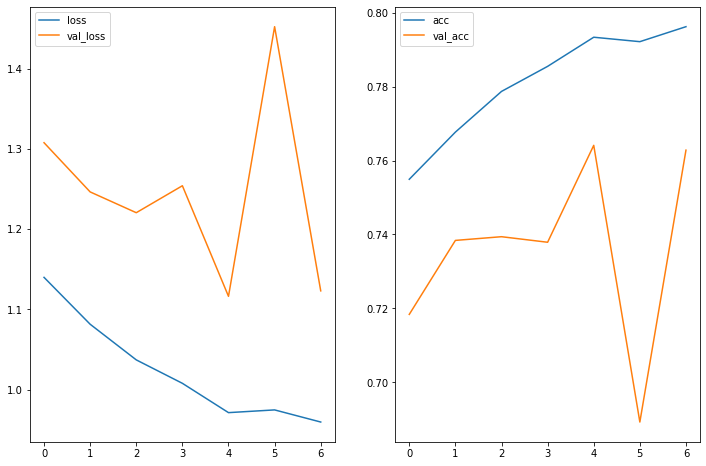

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].plot(hist.history["loss"][1:], label="loss");
axes[0].plot(hist.history["val_loss"][1:], label="val_loss");
axes[0].legend();

axes[1].plot(hist.history["outputs3_acc"][1:], label="acc");
axes[1].plot(hist.history["val_outputs3_acc"][1:], label="val_acc");
axes[1].legend();

Text(0.5, 1.0, 'Training and Validation Loss')

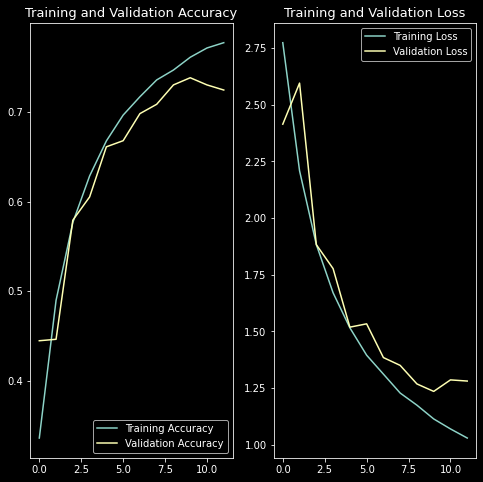

In [ ]:
epochs = 12
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.plot(range(epochs), hist.history["outputs_sparse_categorical_accuracy"], label="Training Accuracy")
ax1.plot(range(epochs), hist.history["val_outputs_sparse_categorical_accuracy"], label="Validation Accuracy")
ax1.legend(loc="lower right")
ax1.set_title("Training and Validation Accuracy", size=13)

ax2.plot(range(epochs), hist.history["loss"], label="Training Loss")
ax2.plot(range(epochs), hist.history["val_loss"], label="Validation Loss")
ax2.legend(loc="upper right")
ax2.set_title("Training and Validation Loss", size=13)

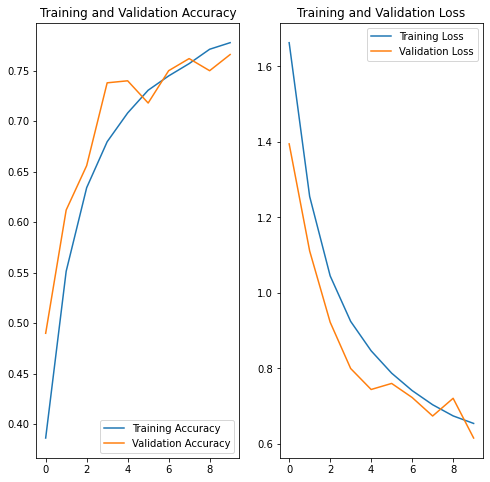

In [ ]:
# import matplotlib.pyplot as plt

# acc = history.history["dense_4_accuracy"]
# val_acc = history.history["val_dense_4_accuracy"]

# loss = history.history["dense_4_loss"]
# val_loss = history.history["val_dense_4_loss"]

# epochs_range = range(10)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc,  label="Training Accuracy")
# plt.plot(epochs_range, val_acc, label="Validation Accuracy")
# plt.legend(loc="lower right")
# plt.title("Training and Validation Accuracy")

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label="Training Loss")
# plt.plot(epochs_range, val_loss, label="Validation Loss")
# plt.legend(loc="upper right")
# plt.title("Training and Validation Loss")
# plt.show()

# Inference